In [14]:
import numpy as np
import networkx as nx
from networkx import community as com
import itertools
import matplotlib.pyplot as plt
from scipy.integrate import odeint

#Run this cell to create load graph to be analyzed
elist = np.loadtxt('network_disease.dat',dtype=int)
N = elist.max()
G = nx.Graph()
G.add_nodes_from(range(1,N+1))
G.add_edges_from(elist)

In [4]:
def SInet(G,i0=1,x0=0.001,beta=1.0,delta=1.0,omega=80.0,tf=0.4,Nt=1000):
    """
    Simulate naive network-SI model with time-periodic transmission

    Input:
    G: Networkx graph (simple, connected, undirected with nodes numbered from 1 to N)
    i0: node which is initially infected
    x0: magnitude of initial condition
    beta,delta, omega: model parameters
    tf,Nt: Solutions are computed at Nt time steps from t=0 to t=tf (see code below)

    Output:
    tarray: Nt+1-element array of times at which solution is output
    xarray: Nt+1 x N Numpy array containing <x> across network nodes at each time step.
    """

    N = G.number_of_nodes()
    xarray = np.zeros((Nt+1,N))
    xarray[0,i0-1] = x0 # initial condition
    tarray = np.linspace(0,tf,Nt+1) # times at which solution should be returned
    
    adj_matrix = nx.adjacency_matrix(G)
    
    def RHS(x,t):
        """Compute RHS of model at time t
        input: x should be a size N array corresponding to <x(t)> for all nodes
        output: dxdt, also a size N array corresponding to d<x>/dt for all nodes
        """
        dot_product = adj_matrix.dot(x)
        dxdt = beta*(1 + delta*np.cos(omega*t))*(1-x)*(dot_product)
        return dxdt

    xarray = odeint(RHS, xarray[0], tarray)    
    return tarray,xarray

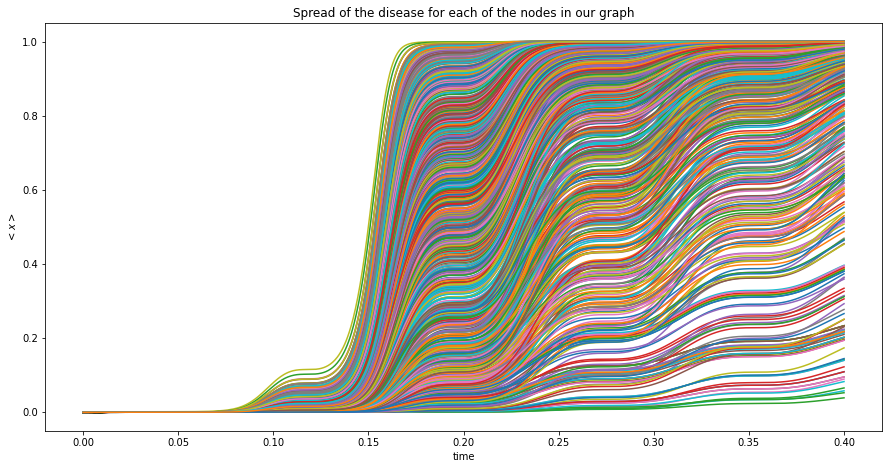

In [7]:
# Find tarray and xarray in the case where the node which is initially infected is the one with max degree
k = np.array(nx.degree(G),dtype=int)[:,1]
i0 = np.argmax(k)+1
tarray_G,xarray_G = SInet(G,i0)

# Plot the spread of the disease for each node
plt.figure(figsize = (15,7.5))
plt.plot(tarray_G, xarray_G)
plt.xlabel("time")
plt.ylabel("$<x>$")
plt.title("Spread of the disease for each of the nodes in our graph")
plt.show()

The first graph shows the spread of the disease for each of the nodes. The plot is not very clear as there are many curves, but we can see that we start from zero in almost all of the nodes initially and then some of the nodes rapidly increase to one(i.e become infected) whilst others increase much slower. To make the plot more clear we will calculate the average $<x>$ across all nodes.

C:\Users\Admin\AppData\Local\Temp\ipykernel_7588\1055783442.py:24: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G)


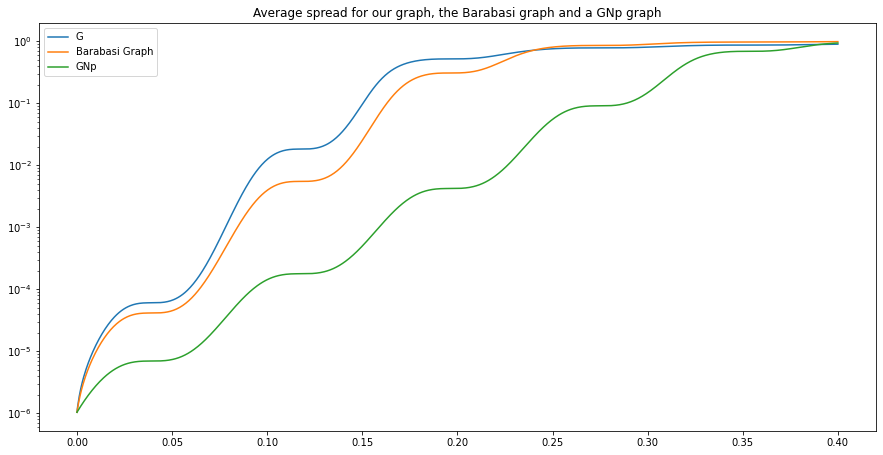

In [22]:
# Comparison with GNp graph and B-A graph, all with initially infected node with largest degree 

# Compute average degree for our graph
k_average = 2*G.number_of_edges()/(G.number_of_nodes())

# Create GNp graph with similar k as for our graph
GNp = nx.gnp_random_graph(G.number_of_nodes(),k_average/(G.number_of_nodes()-1))

# Create Barabasi-Albert with same k as for our graph 
Barabasi_Graph = nx.barabasi_albert_graph(G.number_of_nodes(), int(k_average//2+1))

# Compute average spread across all nodes for our graph
tarray_G,xarray_G = SInet(G,i0)
newarray_G = [0 for x in xarray_G]
for i in range(len(xarray_G)):
    newarray_G[i] = sum(xarray_G[i])/len(xarray_G[0])

# Compute average spread for GNp
degrees_GNp = np.array(nx.degree(GNp),dtype=int)[:,1]
i0_GNp = np.argmax(degrees_GNp)+1
tarray_GNp,xarray_GNp = SInet(GNp,i0=i0_GNp)
newarray_GNp = [0 for x in xarray_GNp]
for i in range(len(xarray_GNp)):
    newarray_GNp[i] = sum(xarray_GNp[i])/len(xarray_GNp[0])

# Compute average spread for Barabasi Alber
degrees_Barabasi_Graph = np.array(nx.degree(Barabasi_Graph),dtype=int)[:,1]
i0_Barabasi_Graph = np.argmax(degrees_Barabasi_Graph)+1
tarray_Barabasi_Graph,xarray_Barabasi_Graph=SInet(Barabasi_Graph,i0=i0_Barabasi_Graph)
newarray_Barabasi_Graph = [0 for x in xarray_Barabasi_Graph]
for i in range(len(xarray_Barabasi_Graph)):
    newarray_Barabasi_Graph[i] = sum(xarray_Barabasi_Graph[i])/len(xarray_Barabasi_Graph[0])

# Plot average spread for the three graphs
plt.figure(figsize = (15,7.5))
plt.semilogy(tarray_G,newarray_G,label = "G")
plt.semilogy(tarray_Barabasi_Graph,newarray_Barabasi_Graph, label = "Barabasi Graph")
plt.semilogy(tarray_GNp,newarray_GNp, label = "GNp")
plt.legend()
plt.title("Average spread for our graph, the Barabasi graph and a GNp graph")
plt.show()

Here we have a semi-log plot of the average spread of the disease (i.e average $<x>$ for all nodes) in three graphs - the graph we have imported, a Barabasi-Albert graph and a Random graph (GNp). In all three cases we have chosen the graphs to have the same number of nodes as our graph and have also fixed approximately the same average degree. Furhter, the initial infected node is the node with highest degree in all three cases.

From the plot we can see that the disease spreads the fastest in our graph, and slowest in the GNp model. Further, we notice that the Barabasi-Albert model and our graph have very similar trajectory. Hence, we can ask ourselves whether there are some similarities between the two graphs, i.e perhaps our graph has similar structure to the Barabasi-Albert model. 


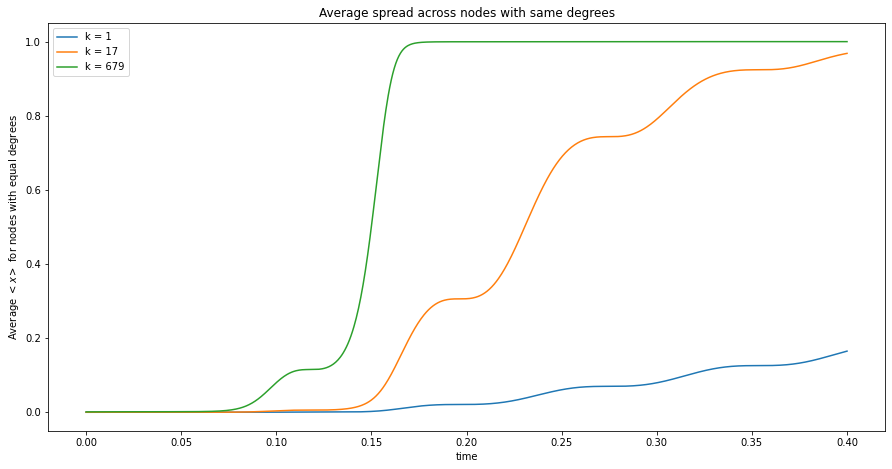

In [13]:
# Nodes with degrees 1, 679(largest degree) and 17(randomly chosen)
degree_one = []
degree_seventeen = []
degree_max = []
for i in G.nodes():
    if G.degree(i) == 1:
        degree_one.append(i)
    if G.degree(i) == 17:
        degree_seventeen.append(i)
    if G.degree(i) == G.degree(i0):
        degree_max.append(i)

# Create a function that calculates the average spread across nodes from a list
def Average_Degree(degree_list):
    xarray = [0 for item in xarray_G]
    for i in range(len(xarray_G)):
        total = 0
        for j in degree_list:
            total = total + xarray_G[i][j-1]
        xarray[i] = total/len(degree_list)
    return xarray

# Plot average spread across nodes with the same degrees
plt.figure(figsize = (15,7.5))
plt.plot(tarray_G,Average_Degree(degree_one), label = "k = 1")
plt.plot(tarray_G,Average_Degree(degree_seventeen), label = "k = 17")
plt.plot(tarray_G,Average_Degree(degree_max), label = "k = 679")
plt.title("Average spread across nodes with same degrees")
plt.xlabel("time")
plt.ylabel("Average $<x>$ for nodes with equal degrees")
plt.legend()
plt.show()

Finally, we have computed the average spread of the disease across the nodes with the same degrees. We have chosen to compare the spread across the nodes with degrees one, the node with the largest degree and the nodes with degree seventeen. As one might expect, the disease spreads much faster at the node with largest degree and very slowly for the nodes with degree one. The nodes with degree seventeed are somewhat in the middle.


In [15]:
communities_list = []
out = com.girvan_newman(G)
k = 5
for communities in itertools.islice(out, k):
    communities_list.append(tuple(sorted(c) for c in communities))
    print("G-N partition with %d communities" %len(communities_list[-1]))
    print("modularity= ", com.modularity(G,communities_list[-1]))
    print("-------------------")

G-N partition with 2 communities
modularity=  0.00010629251220121766
-------------------
G-N partition with 3 communities
modularity=  0.00021256241859365487
-------------------
G-N partition with 4 communities
modularity=  0.00042497648656813266
-------------------
G-N partition with 5 communities
modularity=  0.0006371150462498843
-------------------
G-N partition with 6 communities
modularity=  0.0006370726603587031
-------------------


We have run the Girvan Newman algorithm for our graph and we see that we obtain maximum modularity with 5 communities (after that the modularity starts to decline).

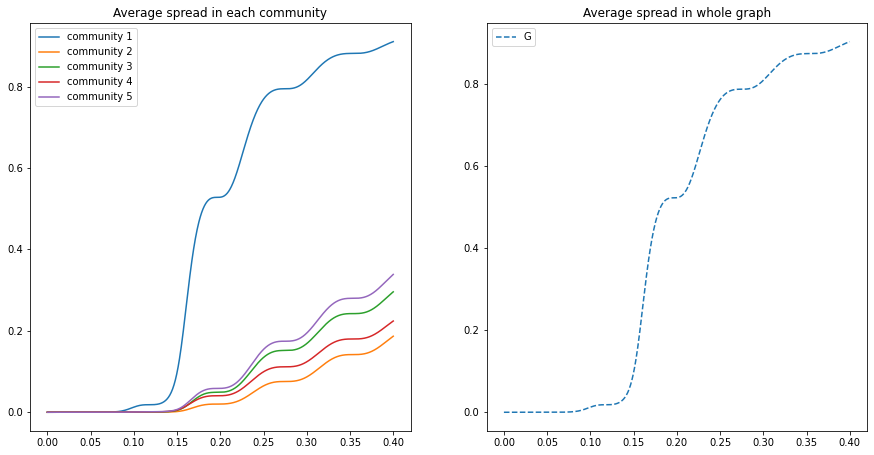

In [19]:
# Function that plots the spread in one of the six communities
def spread_in_community(community_number,xarray):
    array = [0 for x in xarray]
    for i in communities_list[-2][community_number]:
        for j in range(len(xarray)):
            array[j] = array[j] + xarray[j][i-1]/len(communities_list[-2][community_number])
    ax1.plot(tarray_G, array, label = "community {}".format(community_number+1))
    return 

# Plot the average spread in each community
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,7.5))
for i in range(5):
    spread_in_community(i,xarray_G)
ax1.legend()
ax1.title.set_text("Average spread in each community")

# Plot the average spread of the disease in the whole graph
ax2.plot(tarray_G, newarray_G, "--", label = "G")
ax2.title.set_text("Average spread in whole graph")
ax2.legend()
plt.show()

Here we have computed the average spread of the disease across the nodes in each of the five communities. We can see that the disease spreads much faster in the first community than the other four. Further we have shown the average spread across all nodes in the whole graph in the second plot. We can see that it resembles the trajectory of the spread in community $1$, so we can deduce that community $1$ is the largest and has the biggest impact on the spread of the disease. Indeed we can check that most of the nodes are in the first community.

The spread across the other four communities is, as one might expect, much slower, since they are rather separated from the infection for most of the time. Next, we will see what happens when the initial infected node is not the one with the largest degree, but one from one of the smaller communities.

In [20]:
# Change initial infected node to one from the smaller communities (was previously with largest degree)

# Print community 2
communities_list[-2][1]

[43, 784]

We have printed the second community which consists only of two nodes. We will chose the initial infected node to be $43$.

C:\Users\Admin\AppData\Local\Temp\ipykernel_7588\1055783442.py:24: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G)


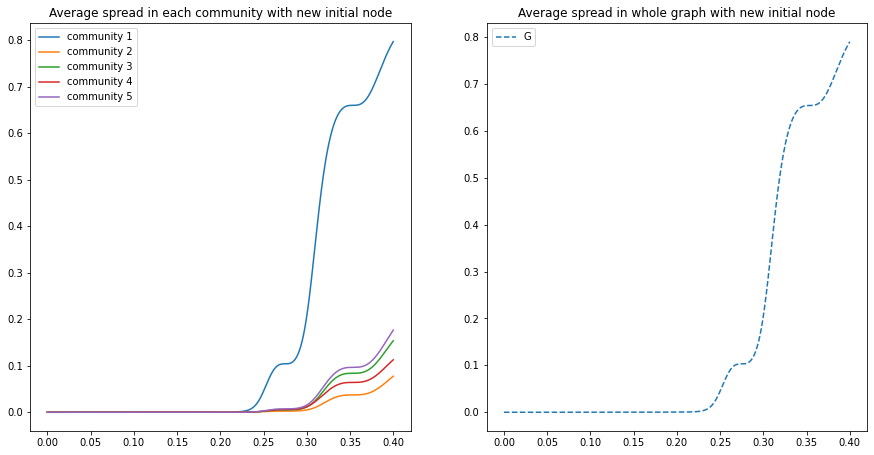

In [21]:
# Pick node 43 as initial node
time, spread = SInet(G, i0 = 43)

# Plot the average spread in each comunity with this new initial infected node
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,7.5))
for i in range(5):
    spread_in_community(i,spread)
ax1.legend()
ax1.title.set_text("Average spread in each community with new initial node")

# Compute average spread with this initial node
spread_average = [0 for x in spread]
for i in range(len(spread)):
    spread_average[i] = sum(spread[i])/len(spread[0])

# Plot the average spread of the disease in the whole graph with the new initial node
ax2.plot(time, spread_average, "--", label = "G")
ax2.title.set_text("Average spread in whole graph with new initial node")
ax2.legend()
plt.show()

Now the disease starts out in a much smaller community than before and therefore it takes much longer for the disease to spread across other communities. This is why we observe that the rapid jump in the largest community comes much later in time (around time $0.30$, wherease the previous growth was around time $0.15$ in community $1$). Therefore we see that the community structure of the graph has impact on the spread of the disease - if the disease starts out in a smaller community it takes much longer for it to spread.

